## Imports

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = 'C:/Users/91845/Desktop/projects/product_embeddings/config'
import random
import datetime
import math
import zipfile
import glob

import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from keras import backend  as K
from keras.layers import (
    Input, 
    Embedding, 
    Dot, 
    Dense, 
    Multiply, 
    Concatenate
)
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.utils import plot_model

## Magic Terminal

In [7]:
!kaggle competitions download -c instacart-market-basket-analysis


  0%|          | 0.00/196M [00:00<?, ?B/s]
  1%|          | 1.00M/196M [00:01<04:14, 803kB/s]
  1%|          | 2.00M/196M [00:01<02:30, 1.35MB/s]
  2%|▏         | 3.00M/196M [00:02<01:48, 1.87MB/s]
  2%|▏         | 4.00M/196M [00:02<01:27, 2.30MB/s]
  3%|▎         | 5.00M/196M [00:02<01:19, 2.53MB/s]
  3%|▎         | 6.00M/196M [00:02<01:14, 2.68MB/s]
  4%|▎         | 7.00M/196M [00:03<01:08, 2.89MB/s]
  4%|▍         | 8.00M/196M [00:03<01:08, 2.89MB/s]
  5%|▍         | 9.00M/196M [00:04<01:06, 2.94MB/s]
  5%|▌         | 10.0M/196M [00:04<01:09, 2.83MB/s]
  6%|▌         | 11.0M/196M [00:04<01:11, 2.72MB/s]
  6%|▌         | 12.0M/196M [00:05<01:07, 2.88MB/s]
  7%|▋         | 13.0M/196M [00:05<01:04, 2.96MB/s]
  7%|▋         | 14.0M/196M [00:05<01:04, 2.98MB/s]
  8%|▊         | 15.0M/196M [00:06<01:09, 2.73MB/s]
  8%|▊         | 16.0M/196M [00:06<01:06, 2.83MB/s]
  9%|▊         | 17.0M/196M [00:06<01:03, 2.98MB/s]
  9%|▉         | 18.0M/196M [00:07<01:01, 3.04MB/s]
 10%|▉         | 19.0

## Code

In [8]:
BASE_DIR_PATH = 'C:/Users/91845/Desktop/projects/product_embeddings/data/instacart-market-basket-analysis'
DATASET_FILEPATH = 'C:/Users/91845/Desktop/projects/product_embeddings/data/instacart-market-basket-analysis/prepared_dataset'

In [23]:
# load orders data
orders_priors = pd.read_csv(f'{BASE_DIR_PATH}/order_products__prior.csv/order_products__prior.csv')
orders_train = pd.read_csv(f'{BASE_DIR_PATH}/order_products__train.csv/order_products__train.csv')

# concatenate the data
df_orders = pd.concat([orders_priors, orders_train], axis=0)

In [31]:
# info about the train data
print(f'Total rows: {len(df_orders)}')
print(f'Shape: {df_orders.shape}')
print(f'Total unique orders: {df_orders.order_id.nunique()}')
print(f'Total unique products: {df_orders.product_id.nunique()}')

Total rows: 33819106
Shape: (33819106, 4)
Total unique orders: 3346083
Total unique products: 49685


In [26]:
df_orders.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [48]:
random.seed(42)
process_orders_per_batch = 50000
orders_list = list(df_orders.order_id.unique())
total_orders_count = df_orders.order_id.nunique()
cols_to_consider = ['order_id', 'product_id']
random.shuffle(orders_list)

start_time = datetime.datetime.now()
counter: int = 0
for i in tqdm(range(math.ceil(total_orders_count/process_orders_per_batch))):
    # take first 50k orders
    orders = orders_list[i*process_orders_per_batch: min((i+1)*process_orders_per_batch, total_orders_count)]
    df_orders_compressed = df_orders[df_orders.order_id.isin(orders)][cols_to_consider].reset_index(drop=True)

    # For negative sampling, keep a random column of product ids with a separate column n as well
    product_ids = list(df_orders_compressed.product_id)
    random.shuffle(product_ids)
    df_orders_compressed['product_id_complement'] = product_ids
    
    # Positive Sampling
    # Self join for positive sampling
    df_positive = pd.merge(
        df_orders_compressed.rename(columns={'product_id': 'product_id1'}), 
        df_orders_compressed.rename(columns={'product_id': 'product_id2'}),
        on='order_id'
    )
    df_positive = df_positive.loc[df_positive.product_id1 != df_positive.product_id2]
    df_positive['label'] = 1

    # Negative
    # Self join for negative sampling
    df_negative = pd.merge(
        df_orders_compressed.rename(columns={'product_id': 'product_id1'}),
        df_orders_compressed.rename(columns={'product_id_complement': 'product_id2'}),
        on='order_id'
    )
    df_negative = df_negative.loc[df_negative.product_id1 != df_negative.product_id2]
    df_negative['label'] = 0

    df_tmp = pd.concat([df_positive, df_negative], axis=0)
    df_tmp = df_tmp.sample(frac=1).rename(columns={
        'product_id1': 'pid1', 
        'product_id2': 'pid2'
    })
    counter += df_tmp.shape[0]
    df_tmp[['pid1', 'pid2', 'label']].to_csv(f'{DATASET_FILEPATH}/file_{counter}.csv', index=False, header=True)

end_time = datetime.datetime.now()
total_time = (end_time - start_time).total_seconds()/60
print(f'Total time taken: {total_time}')

100%|██████████| 67/67 [29:19<00:00, 26.26s/it]

Total time taken: 29.32937766666667


In [9]:
# load the products data to memory
products_df = pd.read_csv(f'{BASE_DIR_PATH}/products.csv/products.csv')

In [10]:
# print info about the products data
print(f'Total unique products: {products_df.product_id.nunique()}')
print(f'Total rows: {len(products_df)}')
print(f'Total unique aisles: {products_df.aisle_id.nunique()}')
print(f'Total unique departments: {products_df.department_id.nunique()}')

Total unique products: 49688
Total rows: 49688
Total unique aisles: 134
Total unique departments: 21


In [11]:
# map each product to aisle id and department id
total_products = len(products_df)
aisle_map: dict = dict()
department_map: dict = dict()
for ix, row in tqdm(products_df.iterrows(), total=total_products):
    department_map[row['product_id']] = row['department_id']
    aisle_map[row['product_id']] = row['aisle_id']

max_products = products_df.product_id.nunique() + 1
max_aisles = products_df.aisle_id.nunique() + 1
max_departments = products_df.department_id.nunique() + 1

max_products, max_aisles, max_departments

100%|██████████| 49688/49688 [00:01<00:00, 43237.14it/s]


(49689, 135, 22)

## Modeling

In [12]:
input_shape = 1
output_shape = 1
embedding_shape_item = 64
embedding_shape_dept_aisle = 16

first_input_pid = Input(shape=(input_shape, ))
first_input_dept_id = Input(shape=(input_shape, ))
first_input_aisle_id = Input(shape=(input_shape, ))

second_input_pid = Input(shape=(input_shape, ))
second_input_dept_id = Input(shape=(input_shape, ))
second_input_aisle_id = Input(shape=(input_shape, ))

embedding_layer_pid = Embedding(
    max_products, 
    embedding_shape_item, 
    embeddings_initializer = 'uniform', 
    embeddings_regularizer = None, 
    activity_regularizer = None, 
    embeddings_constraint = None, 
    mask_zero = False, 
    input_length = input_shape
)

embedding_layer_dept = Embedding(
    max_departments, 
    embedding_shape_dept_aisle, 
    embeddings_initializer = 'uniform', 
    embeddings_regularizer = None,
    activity_regularizer = None,
    embeddings_constraint = None,
    mask_zero = False, 
    input_length = input_shape
)

embedding_layer_aisles = Embedding(
    max_aisles, 
    embedding_shape_dept_aisle, 
    embeddings_initializer = 'uniform', 
    embeddings_regularizer = None,
    activity_regularizer = None,
    embeddings_constraint = None,
    mask_zero = False, 
    input_length = input_shape
)

In [13]:
# embedding layer for both inputs
first_input_encoded_pid = embedding_layer_pid(first_input_pid)
first_input_encoded_dept_id = embedding_layer_dept(first_input_dept_id)
first_input_encoded_aisle_id = embedding_layer_aisles(first_input_aisle_id)

second_input_encoded_pid = embedding_layer_pid(second_input_pid)
second_input_encoded_dept_id = embedding_layer_dept(second_input_dept_id)
second_input_encoded_aisle_id = embedding_layer_aisles(second_input_aisle_id)

first_input_encoded_concatenated = Concatenate()([
    first_input_encoded_pid, 
    first_input_encoded_dept_id, 
    first_input_encoded_aisle_id
])
second_input_encoded_concatenated = Concatenate()([
    second_input_encoded_pid, 
    second_input_encoded_dept_id, 
    second_input_encoded_aisle_id
])

# multiplication layer
# element wise dot product
dot_product = Multiply()([
    first_input_encoded_concatenated, 
    second_input_encoded_concatenated
])

# adding more dense layers
dense_layer1 = Dense(16, activation='relu')(dot_product)
dense_layer2 = Dense(8, activation='relu')(dense_layer1)

# output layer 
y = Dense(1, activation='sigmoid')(dense_layer2)

final_model = Model(inputs=[
    first_input_pid, 
    first_input_dept_id, 
    first_input_aisle_id, 
    second_input_pid, 
    second_input_dept_id, 
    second_input_aisle_id
], outputs=y)

final_model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

In [14]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_15 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_16 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                              

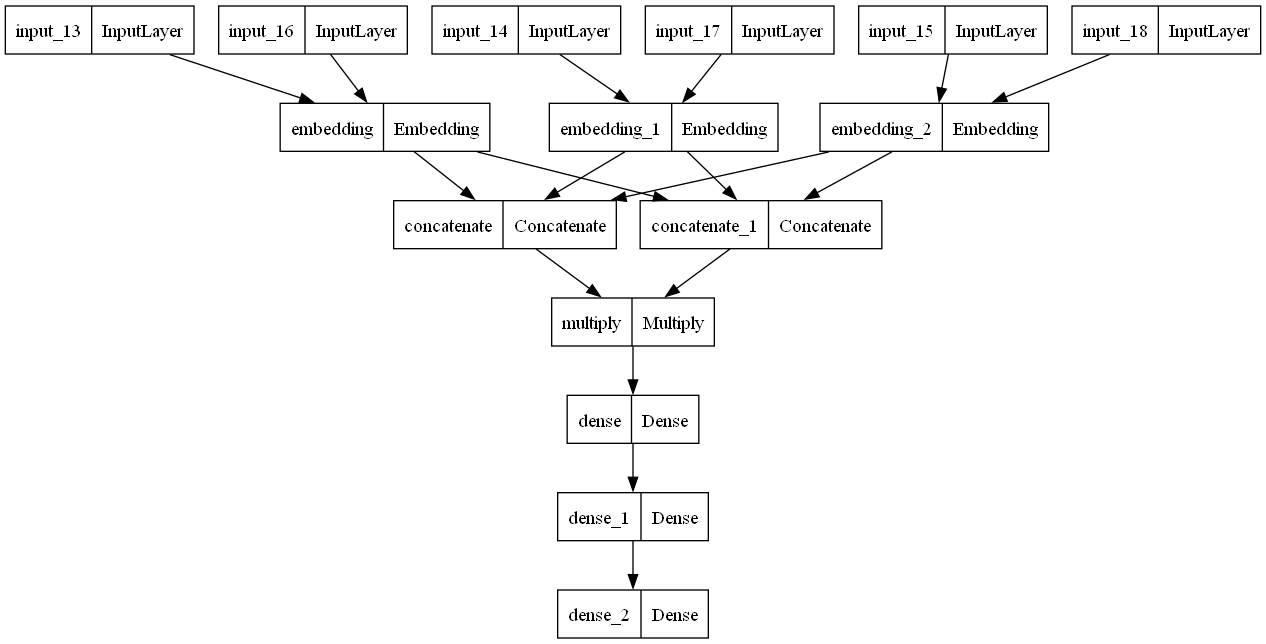

In [15]:
plot_model(final_model)

In [10]:
all_files = glob.glob(os.path.join(DATASET_FILEPATH, '*.csv'))

In [11]:
def generate_batches_val(files, batch_size, val_split): 
    counter = 0

    while True: 
        fname = files[counter]

        counter = (counter + 1)%len(files)
        batch = pd.read_csv(fname)

        batch['dept_id1'] = batch['pid1'].apply(lambda p: department_map[p])
        batch['aisle_id1'] = batch['pid1'].apply(lambda p: aisle_map[p])

        batch['dept_id2'] = batch['pid2'].apply(lambda p: department_map[p])
        batch['aisle_id2'] = batch['pid2'].apply(lambda p: aisle_map[p])

        for local_index in range(0, batch.shape[0], batch_size):
            till = int(batch_size*(1-val_split))
            from_idx = local_index
            to_idx = local_index + batch_size - till

            input_local_pid1 = batch.iloc[from_idx:to_idx]['pid1']
            input_local_dept_id1 = batch.iloc[from_idx:to_idx]['dept_id1']
            input_local_aisle_id1 = batch.iloc[from_idx:to_idx]['aisle_id1']
            
            input_local_pid2 = batch.iloc[from_idx:to_idx]['pid2']
            input_local_dept_id2 = batch.iloc[from_idx:to_idx]['dept_id2']
            input_local_aisle_id2 = batch.iloc[from_idx:to_idx]['aisle_id2']

            output_local = batch.iloc[from_idx:to_idx]['label']
            yield [
                np.array(input_local_pid1),
                np.array(input_local_dept_id1), 
                np.array(input_local_aisle_id1), 
                np.array(input_local_pid2), 
                np.array(input_local_dept_id2),
                np.array(input_local_aisle_id2)
            ], np.array(output_local).reshape((-1, 1))


def generate_batches_train(files, batch_size, val_split): 
    counter = 0

    while True: 
        fname = files[counter]

        counter = (counter + 1)%len(files)
        batch = pd.read_csv(fname)

        batch['dept_id1'] = batch['pid1'].apply(lambda p: department_map[p])
        batch['aisle_id1'] = batch['pid1'].apply(lambda p: aisle_map[p])

        batch['dept_id2'] = batch['pid2'].apply(lambda p: department_map[p])
        batch['aisle_id2'] = batch['pid2'].apply(lambda p: aisle_map[p])

        for local_index in range(0, batch.shape[0], batch_size):
            till = int(batch_size*(1-val_split))
            from_idx = local_index + batch_size - till
            to_idx = local_index + batch_size

            input_local_pid1 = batch.iloc[from_idx:to_idx]['pid1']
            input_local_dept_id1 = batch.iloc[from_idx:to_idx]['dept_id1']
            input_local_aisle_id1 = batch.iloc[from_idx:to_idx]['aisle_id1']
            
            input_local_pid2 = batch.iloc[from_idx:to_idx]['pid2']
            input_local_dept_id2 = batch.iloc[from_idx:to_idx]['dept_id2']
            input_local_aisle_id2 = batch.iloc[from_idx:to_idx]['aisle_id2']

            output_local = batch.iloc[from_idx:to_idx]['label']

            yield [
                np.array(input_local_pid1),
                np.array(input_local_dept_id1), 
                np.array(input_local_aisle_id1), 
                np.array(input_local_pid2), 
                np.array(input_local_dept_id2),
                np.array(input_local_aisle_id2)
            ], np.array(output_local).reshape((-1, 1))

In [12]:
BATCH_SIZE: int = 8000
VAL_SPLIT: float = 0.15

train_files = all_files

train_generator = generate_batches_train(files=train_files, batch_size=BATCH_SIZE, val_split=VAL_SPLIT)
val_generator = generate_batches_val(files=train_files, batch_size=BATCH_SIZE, val_split=VAL_SPLIT)

In [17]:
checkpoint_filepath = 'C:/Users/91845/Desktop/projects/product_embeddings/models/best_model.h5'

In [18]:
EPOCHS_CNT: int = 100

mc = ModelCheckpoint(
    checkpoint_filepath, 
    monitor='val_accuracy', 
    mode='max', 
    verbose=1, 
    save_best_only=True
)

In [ ]:
hist = final_model.fit(
    steps_per_epoch=len(train_files)*10, 
    x=train_generator, 
    verbose=1, 
    max_queue_size=32, 
    validation_data=val_generator,
    validation_steps=len(train_files)*10, 
    epochs=EPOCHS_CNT, 
    callbacks=[mc]
)

In [19]:
# load the best model's weights
final_model.load_weights(checkpoint_filepath)

In [20]:
# print all the layer names
for layer in final_model.layers:
    print(layer.name)

input_13
input_14
input_15
input_16
input_17
input_18
embedding
embedding_1
embedding_2
concatenate
concatenate_1
multiply
dense
dense_1
dense_2


In [25]:
# fetch the output of the product embedding layer, which will be the product embeddings
# when passed through the embedding layers. Inputs are product_ids
embedding_layer_index = 6
embedding_layer_name = final_model.layers[embedding_layer_index].name

inter_output_model = Model([
    first_input_pid
], final_model.get_layer(embedding_layer_name).output)

inter_output = inter_output_model.predict(list(range(1, max_products)))

   1/1553 [..............................] - ETA: 3:31

c:\Users\91845\Desktop\projects\product_embeddings\venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1553/1553 [==============================] - 2s 1ms/step


In [27]:
embeddings = []
product_ids = []
for ix, i in enumerate(list(range(1, max_products))):
    embeddings.append(inter_output[ix][0])
    product_ids.append(i)

In [32]:
df_embeddings = pd.DataFrame(np.array(embeddings))
df_embeddings['product_id'] = product_ids
df_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,product_id
0,0.095012,-0.355277,0.025518,-0.221452,0.215679,0.364072,0.127606,0.202834,-0.179737,-0.065435,...,-0.276285,0.134097,0.082072,-0.184722,0.296360,0.022569,-0.150038,-0.150001,-0.185023,1
1,-0.127678,-0.200196,-0.093851,-0.016951,0.053544,-0.017947,-0.015705,0.230071,0.114878,-0.008826,...,0.024064,-0.068978,-0.211658,0.253677,0.063402,-0.034649,-0.095657,-0.128695,-0.140550,2
2,-0.095404,-0.312200,-0.064646,-0.031511,0.094173,0.079778,-0.030069,0.175691,-0.186072,-0.082559,...,-0.079114,0.133827,-0.173287,0.089089,-0.143673,0.085770,-0.181757,0.210091,0.109437,3
3,-0.166871,0.044443,-0.020196,0.006492,0.119625,0.154954,-0.155944,-0.244357,0.060949,0.152253,...,0.161000,-0.165485,0.275301,-0.053605,0.281979,-0.123943,-0.145359,0.034982,0.039031,4
4,0.018453,-0.035141,0.016732,-0.015968,0.023589,-0.034492,0.018320,-0.048218,0.043288,-0.048312,...,0.032221,0.034114,0.045352,-0.043304,0.047741,0.002089,0.000944,-0.032752,-0.003786,5


In [36]:
df_embeddings.to_csv(
    os.path.abspath(os.path.join(BASE_DIR_PATH, '..', 'embeddings.csv'))
)


In [37]:
product_map = {}
dept_map = {}
for ix, row in products_df.iterrows():
    product_map[row['product_id']] = row['product_name']
    dept_map[row['product_id']] = row['department_id']


In [50]:
import math
embedding_size = 64
top_k = 5

def find_similar(pid, verbose=1):
    print("Item Queried: ", product_map[pid])

    mp = {}
    cur = df_embeddings[df_embeddings.product_id == pid]
    for ix, row in df_embeddings.iterrows():
        if row['product_id'] == pid:
            continue
        else: 
            ans = 0
            for i in range(embedding_size):
                ans += math.pow(
                    (float(row[i]) - float(cur[i])), 
                    2
                )
                mp[row['product_id']] = ans
    
    tmp_lst = sorted(mp.items(), key=lambda x: x[1], reverse=False)

    cnt = 0
    res = []
    for l in tmp_lst:
        x = (l[0], product_map[l[0]], l[1])
        res.append(x)

        if verbose == 1:
            print(x)
        
        cnt += 1
        if cnt == top_k:
            break
    
    return res